### General Strategy

Our team decided to go for the “Risky” portfolio. This means that the goal of our portfolio is to deviate as much as possible from the initial starting value of $500,000. Our aim is to then create a portfolio that is as volatile as possible. We are not concerned whether this portfolio gains or loses value, as our goal is to only deviate from the starting value as much as possible. 

To create a risky portfolio, we first analyze stocks based on Beta. Beta is a measure of a stock’s volatility based on the market’s volatility. We wish to choose stocks with the highest possible Betas, as this means that these investments will move the most relative to the market. 

We also need to ensure that our holdings will be positively correlated. Since we have already filtered for volatile stocks, if they are negatively correlated (meaning they move inversely to each other), then the volatility of both stocks would be mitigated. This means the gains/losses would be offset by each other. We need investments that are positively correlated as they both need to move in the same direction as each other for their returns not to offset. 

Our portfolio will contain the minimum number of stocks allowed, which is 12. We want to avoid diversification as much as possible, as a more diversified portfolio will lead to less variance. The best method to avoid diversification is to have the minimum amount of investments possible. 


In [7]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

### Stock Filtering

The first step in this assignment is to read the “Tickers.csv” file to get all of the provided tickers we have to work with. Then, we must clean this file to ensure that the tickers which are produced both work with our code for analyzing each stock and adhere to the specifications of the assignment. 

When creating our stock filtering function, we create an empty list (filtered_tlist), in which valid tickers are added. 

When evaluating whether a ticker is valid or not, 

Our filter function removes Tickers that may have been delisted, as delisted stocks cannot be held in a portfolio. 

- Duplicate Tickers are removed and only unique tickers are considered. 

- Tickers with less than a volume of 200,000 are removed. 

- Any months with less than 20 trading days are removed. 

- Any stocks that are not denominated in USD are removed. 

For every Ticker that is removed, our code makes a note of which Ticker was removed and why it was removed. 

When all Tickers from “Tickers.csv” are evaluated, the tickers that remain in filtered_tlist are all valid Tickers, which we can then perform our data analysis on and choose from to create our final portfolio. 


In [8]:
file = 'Tickers.csv'
df = pd.read_csv(file, header=None)
#convert dataframe to list of ticker names
ticker_list = [row[0] for row in df.values]

start_date = '2022-01-01'
end_date = '2022-10-31'

tickers_close = {}
tickers_info = {}
filtered_tlist = []

for ticker in ticker_list:
    temp = yf.Ticker(ticker)
    temp_info = temp.info
    temp_hist = temp.history(start=start_date, end=end_date)
    threshold_vol = 200000
    threshold_day = 20
    currency = 'USD'
    average_days_in_month = 30.437
    
    #filtering process
    if temp_hist.empty: 
        print("removed", ticker, "since delisted")
    elif ticker in filtered_tlist:
        print("duplicate ticker:", ticker)
    else:
        
        #splitting the history dataframe of a ticker by month
        group_months = temp_hist.reset_index().groupby(pd.Grouper(key='Date', freq='M'))
        dfs = [group for _,group in group_months]
        filtered_dfs = []
        for i, df in enumerate(dfs):
            #recombine all the months with more trading days than set threshold
            if len(df.index) >= threshold_day:
                filtered_dfs.append(df)
        temp_hist_new = pd.concat(filtered_dfs)
        temp_hist_new.set_index("Date", inplace=True)

        #further filtering for currency and volume thresholds
        if temp_info.get("financialCurrency") != currency:
            print("removed", ticker, "since currency isn't USD")
        elif temp_hist_new['Volume'].mean()*average_days_in_month < threshold_vol:
            print("removed", ticker, "since volume doesn't meet threshold")
        else:
            #add all stocks that pass filters and store their respective data in dictionaries
            tickers_close[ticker] = temp_hist
            tickers_info[ticker] = temp_info
            filtered_tlist.append(ticker)

filtered_tlist 

removed LOPX since currency isn't USD
removed FDEU since currency isn't USD
removed TPGY since currency isn't USD
- OBAS: No data found, symbol may be delisted
removed OBAS since delisted
removed VXX since currency isn't USD
removed EBLU since currency isn't USD
removed IWO since currency isn't USD
removed KONG since currency isn't USD
removed TEAF since currency isn't USD
removed BEPH since currency isn't USD
removed LITM since currency isn't USD
removed GSJY since currency isn't USD
removed ONLN since currency isn't USD
removed CHAU since currency isn't USD
removed OVL since currency isn't USD
removed CHIH since currency isn't USD
removed BNDW since currency isn't USD


['TNXP',
 'YCBD',
 'FTCV',
 'ERH',
 'MNDO',
 'KTRA',
 'CLVS',
 'ORIA',
 'HTLF',
 'RMBS',
 'LEGAU',
 'AMWL',
 'DEA',
 'STRT',
 'EAT',
 'CW',
 'NLOK',
 'OCUL',
 'COF',
 'SFT',
 'DGII',
 'SIOX',
 'TELA',
 'MRUS',
 'PTVE',
 'SELF']

### Ranking Based on Beta

The first step in our analysis is to rank the filtered stocks based on their beta. As stated previously, beta is a measure of a stock’s volatility relative to the market volatility. When trying to create a volatile portfolio, as is our goal, beta is an immensely important factor on which to base our decisions for choosing our final portfolio. 

Our beta function first gets all of the betas using the .info() function and then sorts them into a list from highest to lowest betas. We then focus on the stocks which have the highest betas, as they will be the most attractive for our uses. 


In [9]:
#get market data
start_date = '2022-01-01'
end_date = '2022-10-31'
MarketIndex='^GSPC'
t_market = yf.Ticker(MarketIndex)
MarketIndex_hist = t_market.history(start=start_date, end=end_date)

In [10]:
#gets beta based on given market
def get_beta(ticker, price, m_ticker, market):
  prices = pd.DataFrame(price['Close'])
  prices.columns = [ticker]
  prices[m_ticker] = market['Close']

  daily_returns = prices.pct_change()
  daily_returns.drop(index=daily_returns.index[0], inplace=True)
  monthly_returns=prices.resample('M').ffill().pct_change()
  monthly_returns.drop(index=monthly_returns.index[0], inplace=True)

  MarketVar=monthly_returns[m_ticker].var()
  Beta = monthly_returns.cov()/MarketVar
  return Beta.iat[0,1]

tlist_betas = []
#create nested list with ticker and its beta from info dictionary
for ticker in filtered_tlist:
  temp_beta = get_beta(ticker, tickers_close.get(ticker), MarketIndex, MarketIndex_hist)
  tlist_betas.append([ticker, temp_beta])

#sort tickers by decreasing beta
tlist_betas = sorted(tlist_betas, key = lambda x: x[1], reverse = True)
#convert list to dictionary
tdict_betas = {b[0]: b[1] for b in tlist_betas}

tdict_betas

{'YCBD': 3.9385352097988044,
 'TNXP': 2.5414765935076495,
 'SFT': 2.4815353683817585,
 'EAT': 1.8029518121659678,
 'RMBS': 1.7125289124122516,
 'SIOX': 1.5458124507706446,
 'PTVE': 1.2549185064893578,
 'COF': 1.0174422747691791,
 'CW': 0.9998261793435872,
 'DEA': 0.9913600745743351,
 'NLOK': 0.9499959011641863,
 'STRT': 0.8935064314773518,
 'DGII': 0.8483432622295607,
 'HTLF': 0.8172310630716223,
 'ERH': 0.804871122860208,
 'MNDO': 0.7990093971687299,
 'AMWL': 0.6500153326282511,
 'TELA': 0.6456811630165229,
 'MRUS': 0.5104004712990784,
 'LEGAU': 0.12838964823077284,
 'OCUL': 0.11686552300935674,
 'ORIA': 0.030940583958225586,
 'FTCV': 0.013513669680350754,
 'KTRA': -0.4339366278546419,
 'SELF': -0.6276063198236685,
 'CLVS': -3.1332722080646165}

### Ranking Based on Correlation 

The next step in our analysis is to use the sorted betas list and then assess the correlation of the stocks within that list. It is not enough to only select the 12 stocks that are the most volatile. If volatile stocks are negatively correlated, then their returns offset each other and act as a hedge. To ensure that our holdings do not offset each other, we have to make sure that they are positively correlated, meaning they move in the same direction. Our code creates a correlation matrix, which compares every stock and its correlations to one another. 


In [11]:
#create dataframe of ticker closing values from given tickers
frame = [tickers_close.get(t[0]).rename(columns={'Close':t[0]})[t[0]] for t in tlist_betas]
beta_data = pd.concat(frame, axis=1)

#removing duplicate pairs
def rem_dupe(df):
    cols = df.columns
    #python sets automatically ignore duplicates
    rem = set()
    #iterate through df and add all pairs
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            rem.add((cols[i], cols[j]))
    return rem

#creating a sorted correlation matrix
def sorted_corr(df):
    #unstacking pandas correlation matrix for readability
    corrs = df.corr().unstack()
    #getting the duplicate correlation pairs
    drop = rem_dupe(df)
    return corrs.drop(labels=drop).sort_values(ascending=False) #dropping all the duplicates

top_c = sorted_corr(beta_data)
beta_data.corr()

,YCBD,TNXP,SFT,EAT,RMBS,SIOX,PTVE,COF,CW,DEA,...,AMWL,TELA,MRUS,LEGAU,OCUL,ORIA,FTCV,KTRA,SELF,CLVS
YCBD,1.000000,0.923274,0.898808,0.736091,0.374849,0.811869,0.381002,0.893811,-0.112660,0.826779,...,0.085394,0.770875,0.471691,-0.238224,0.342729,-0.711625,-0.395886,0.859764,0.195134,0.510240
TNXP,0.923274,1.000000,0.957045,0.781966,0.431260,0.889300,0.342230,0.905608,-0.062456,0.803044,...,0.114255,0.861675,0.581211,-0.148110,0.469659,-0.682020,-0.232443,0.924900,0.155430,0.616765
SFT,0.898808,0.957045,1.000000,0.740395,0.490848,0.889719,0.435082,0.865517,-0.050309,0.814320,...,0.268084,0.857156,0.677541,-0.110074,0.571174,-0.660451,-0.156955,0.911147,0.112403,0.664711
EAT,0.736091,0.781966,0.740395,1.000000,0.597318,0.596389,0.294772,0.846883,0.236500,0.555828,...,-0.099586,0.785564,0.429392,0.026110,0.349015,-0.420747,-0.043024,0.702447,0.132922,0.384343
RMBS,0.374849,0.431260,0.490848,0.597318,1.000000,0.309766,0.244572,0.330757,0.712293,0.193849,...,-0.038260,0.602064,0.421873,0.293702,0.377339,-0.028127,0.405580,0.270470,-0.293178,0.077382
SIOX,0.811869,0.889300,0.889719,0.596389,0.309766,1.000000,0.504394,0.811763,-0.156810,0.727799,...,0.378745,0.781113,0.638691,-0.010925,0.625380,-0.605124,-0.047925,0.874309,0.150390,0.673315
PTVE,0.381002,0.342230,0.435082,0.294772,0.244572,0.504394,1.000000,0.399456,0.018570,0.462560,...,0.533210,0.252004,0.351999,0.165580,0.482278,-0.104831,0.079746,0.323244,0.229302,0.224694
COF,0.893811,0.905608,0.865517,0.846883,0.330757,0.811763,0.399456,1.000000,-0.131484,0.795587,...,0.116888,0.780223,0.513000,-0.187137,0.399527,-0.688037,-0.293221,0.887996,0.317995,0.532161
CW,-0.112660,-0.062456,-0.050309,0.236500,0.712293,-0.156810,0.018570,-0.131484,1.000000,-0.198897,...,-0.297422,0.141084,0.067635,0.458229,-0.007987,0.339276,0.522040,-0.245032,-0.443607,-0.201327
DEA,0.826779,0.803044,0.814320,0.555828,0.193849,0.727799,0.462560,0.795587,-0.198897,1.000000,...,0.316715,0.586059,0.584988,-0.290892,0.401044,-0.748921,-0.464173,0.819743,0.277466,0.582194


In [12]:
min_port_size = 12

#coverting two series to list of tuples
def make_tuples(s1, s2):
  return list(zip(s1, s2))

tlist_final = []
for ticker in tlist_betas:

  temp_index = pd.DataFrame(top_c[ticker[0]]).index
  temp_closing = pd.DataFrame(top_c[ticker[0]])[0]

  #create list of tickers with their corresponding correlations with other tickers
  corr_temp = make_tuples(temp_index, temp_closing)

  #check if there are more positively correlated tickers than given minimum portfolio size
  if len([x for x in corr_temp if x[1] > 0]) >= min_port_size:
    #if so, create a new list with the ticker as the first element
    tlist_final.append([ticker[0], ticker[1], 1])

    #and add the remaining stocks with their correlation to the ticker to the list (in descending order)
    for stock in corr_temp:

      if stock[1] > 0 and len(tlist_final) < min_port_size:
        tlist_final.append([stock[0], tdict_betas.get(stock[0]), top_c[ticker[0]][stock[0]]]) #in the form (ticker, beta, correlation)

    #if not, go to the next highest beta ticker and check their correlations
  #end loop if number of tickers reaches desired size
  if len(tlist_final) == min_port_size:
    break

tlist_final

[['YCBD', 3.9385352097988044, 1],
 ['TNXP', 2.5414765935076495, 0.9232740242845484],
 ['SFT', 2.4815353683817585, 0.898808367371399],
 ['COF', 1.0174422747691791, 0.8938112520504867],
 ['MNDO', 0.7990093971687299, 0.8914001716325878],
 ['STRT', 0.8935064314773518, 0.8852761193574838],
 ['KTRA', -0.4339366278546419, 0.8597642047655706],
 ['DEA', 0.9913600745743351, 0.8267792507177361],
 ['NLOK', 0.9499959011641863, 0.8264082443494661],
 ['SIOX', 1.5458124507706446, 0.8118693297637744],
 ['TELA', 0.6456811630165229, 0.7708745525887988],
 ['ERH', 0.804871122860208, 0.7572674642334436]]

### Allocating Weights

We wish to create the riskiest portfolio possible. To do so, we will have our algorithm generate thousands of possible weights for each stock based on a cutoff system. It is composed of the following:
1. Split stocks into two groups based on a risk/correlation tolerance
2. Shift the weights of the groups based on a set increment/decrement value
3. Shift the weights of the stocks within the riskiest group to maximize our desired metric

Additional failsafes are added in the case that no stocks meet our set tolerances.

In [13]:
total = 500000
min_weight = (100/(len(tlist_final)*2))/100
max_weight = 0.25
correlation_cutoff = 0.5
beta_cutoff = 1

beta_gt = []
beta_lt = []

#make sure beta_gt has at least 2 stocks by changing beta cutoff if not filled
#since correlation is more important than beta as we want the portfolio trend to resemble that of the most volatile stock
while len(beta_gt) < 2:
  beta_gt = [stock for stock in tlist_final  if stock[1] >= beta_cutoff and stock[2] >= correlation_cutoff] #betas and correlation greater than cutoff
  beta_lt = [stock for stock in tlist_final  if stock[1] < beta_cutoff or stock[2] < correlation_cutoff] #betas and correlation less than cutoff
  beta_cutoff -= 0.1

print(beta_gt)
print(beta_lt) 

pct_allocated_low = len(beta_lt)*min_weight #lowest possible weight for beta_lt tickers
pct_allocated_high = 1 - pct_allocated_low #greatest possible weight for beta_gt tickers

#adjust weights if allocated weights for beta_gt is too high (i.e. each ticker > max weight)
if pct_allocated_high/len(beta_gt) > max_weight:
  pct_allocated_low += pct_allocated_high - max_weight*len(beta_gt)
  pct_allocated_high = max_weight*len(beta_gt)

print("The weight distribution of beta_gt:beta_lt is " , pct_allocated_low, pct_allocated_high)

[['YCBD', 3.9385352097988044, 1], ['TNXP', 2.5414765935076495, 0.9232740242845484], ['SFT', 2.4815353683817585, 0.898808367371399], ['COF', 1.0174422747691791, 0.8938112520504867], ['SIOX', 1.5458124507706446, 0.8118693297637744]]
[['MNDO', 0.7990093971687299, 0.8914001716325878], ['STRT', 0.8935064314773518, 0.8852761193574838], ['KTRA', -0.4339366278546419, 0.8597642047655706], ['DEA', 0.9913600745743351, 0.8267792507177361], ['NLOK', 0.9499959011641863, 0.8264082443494661], ['TELA', 0.6456811630165229, 0.7708745525887988], ['ERH', 0.804871122860208, 0.7572674642334436]]
The weight distribution of beta_gt:beta_lt is  0.2916666666666667 0.7083333333333333


### The “Inverse” Sharpe Ratio:

In class, we learned about the Sharpe Ratio, which compares the returns of an investment to the risk it has. It does this by taking the average returns of the portfolio subtracting the risk-free rate and dividing that by the Standard Deviation. (As in Assignment 3, we will disregard the risk-free rate). The Sharpe ratio is meant to reward investments that have a high rate of return with a low amount of risk. For the purposes of our decision-making process, we decided to alter the Sharpe Ratio. Instead of measuring investments based on their returns in perspective to their risk, we want to measure investments based on their combined risk and return. Since our goal is to seek out investments with high returns and high volatility, we need to alter the formula. Instead of dividing by the Standard Deviation (which is a measure of risk), we will multiply by the Standard Deviation. This means that our new metric, the “Inverse” Sharpe Ratio now rewards stocks with both high returns and high volatility. 


The formula is as follows:

$Sharpe Ratio=\frac{R_P}{\sigma_P}$

$"Inverse" Sharpe Ratio=|{R_P}\times{\sigma_P}|$

*Note: We will take the absolute value of the returns/standard Deviation as it is possible for the cumulative returns of an investment to be negative, and since we do not care whether our investment gains or losses, we want to equally evaluate stocks that lose value. 

In [14]:
#create portfolios with closing values for beta_gt and beta_lt
frame1 = [tickers_close.get(t[0]).rename(columns={'Close':t[0]})[t[0]] for t in beta_lt]
frame2 = [tickers_close.get(t[0]).rename(columns={'Close':t[0]})[t[0]] for t in beta_gt]
port_lt = pd.concat(frame1, axis=1)
port_gt = pd.concat(frame2, axis=1)

pct_allocated_high_copy = pct_allocated_high
pct_allocated_low_copy = pct_allocated_low

increment = 0.01 #variation in weighting for each iteration, set to 1% on default

#our own version of risk/volatility calculation, "inverse sharpe ratio"
isharpes = []

#calculate greatest possible weight for ticker with heighest beta
#if (allocated weight for beta_gt - lowest possible weight for all tickers other than highest beta in beta_gt) > max weight, then set it to max weight
greatest_possible_weight = max_weight if (pct_allocated_high_copy - min_weight*(len(beta_gt)-1)) > max_weight else (pct_allocated_high_copy - min_weight*(len(beta_gt)-1))

#continue iterations as long as the average weight of beta_gt tickers is greater than min weight,
#and average weight of beta_lt tickers are less than max weight
while pct_allocated_high_copy/len(beta_gt) >= min_weight and pct_allocated_high_copy/len(beta_gt) <= max_weight and pct_allocated_low_copy/len(beta_lt) <= max_weight and pct_allocated_low_copy/len(beta_lt) >= min_weight:

  #reset max weight for each iteration of allocated weights
  iter_weight = greatest_possible_weight

  #continue shifting the weights of the greatest beta ticker and the other beta_gt tickers as long as
  # 1. the weight of the remaining tickers are less than the max weight
  # 2. the weight of the greatest beta ticker is greater than the min weight
  cutoff1 = (pct_allocated_high_copy - iter_weight)/(len(beta_gt)-1)
  cutoff2 = iter_weight
  while cutoff1 <= max_weight and cutoff1 >= min_weight and iter_weight >= min_weight and cutoff2 <= max_weight:
    template = {
          "Ticker": [],
          "Weight": []
    }
    t_portfolio_final = pd.DataFrame(template)
    t_port_gt = port_gt.copy()
    t_port_lt = port_lt.copy()

    #add the greatest beta stock into the portfolio first
    stock = beta_gt[0][0]
    t_port_gt[stock + "_value"] = t_port_gt[stock]*(iter_weight*total/t_port_gt[stock][0])

    #appending the same as above but in the form of the template
    t_row = {"Ticker": stock, "Weight": iter_weight}
    t_portfolio_final = t_portfolio_final.append(t_row, ignore_index=True)

    remaining_weight = pct_allocated_high_copy - iter_weight #weight available to distribute to the remaining beta_gt tickers

    #calculating values for the two portfolios

    for stock_raw in beta_gt[1:]:
      stock = stock_raw[0]
      t_port_gt[stock + "_value"] = t_port_gt[stock]*remaining_weight/(len(beta_gt)-1)*total/t_port_gt[stock][0]

      #appending same as above but in the form of the template
      t_row = {"Ticker": stock,"Weight": remaining_weight/(len(beta_gt)-1)}
      t_portfolio_final = t_portfolio_final.append(t_row, ignore_index=True)

    for stock_raw in beta_lt:
      stock = stock_raw[0]
      t_port_lt[stock + "_value"] = t_port_lt[stock]*(pct_allocated_low_copy/len(beta_lt)*total/t_port_lt[stock][0])

      #appending same as above but in the form of the template
      t_row = {"Ticker": stock, "Weight": pct_allocated_low_copy/len(beta_lt)}
      t_portfolio_final = t_portfolio_final.append(t_row, ignore_index=True)

    #joining the two portions together
    t_port_final = pd.concat([t_port_gt, t_port_lt], axis=1)

    #calculating rate of return for the entire portfolio
    t_port_final['port_val'] = t_port_final[[col for col in t_port_final.columns if col.endswith('_value')]].sum(axis=1)
    t_port_final['pct_change'] = t_port_final['port_val'].pct_change()

    # "inverse sharpe ratio"
    isharpe = abs(t_port_final['pct_change'].mean() * t_port_final['pct_change'].std())

    #calculate total return for comparison purposes
    port_return =  float(t_port_final['port_val'].iloc[-1]) - float(t_port_final['port_val'].iloc[0])

    #shift index of portfolio to start at 1
    t_portfolio_final.index += 1 

    isharpes.append([isharpe, pct_allocated_high_copy, pct_allocated_low_copy, iter_weight, port_return, t_port_final, t_portfolio_final])
    iter_weight -= increment #shift weight of greatest beta tickers vs rest of the tickers by increment

  #shift weight of beta_gt and beta_lt tickers by increment
  pct_allocated_high_copy -= increment
  pct_allocated_low_copy += increment

Portfolio_Final = max(isharpes)[-1]

C:\Users\felix\AppData\Local\Temp\ipykernel_51260\1203968875.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_portfolio_final = t_portfolio_final.append(t_row, ignore_index=True)
C:\Users\felix\AppData\Local\Temp\ipykernel_51260\1203968875.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_portfolio_final = t_portfolio_final.append(t_row, ignore_index=True)
C:\Users\felix\AppData\Local\Temp\ipykernel_51260\1203968875.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_portfolio_final = t_portfolio_final.append(t_row, ignore_index=True)
C:\Users\felix\AppData\Local\Temp\ipykernel_51260\1203968875.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [15]:
print("The best portfolio has an isharpe ratio of", max(isharpes)[0])

The best portfolio has an isharpe ratio of 0.00010478982966866132


### Relation Between Risky Weights and Inverse Sharpe Ratio

As observed from the graph below, there is a strictly positively correlated trend between our "inverse Sharpe ratio" and the weight of the high beta/correlation cutoff portion of our portfolio.
It can also be seen that the various iterations of the weights between the highest beta stock and the rest of its counterparts also has a nearly linear correlation. This implies that the more weight that is put into more volatile stocks, the more "risky" the portfolio becomes (which supports our initial hypothesis)


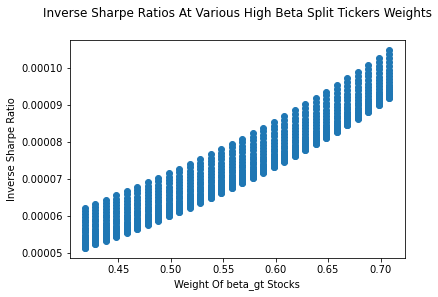

In [16]:
#make graph for inverse sharpe ratio
isharpe_values = [s[0] for s in isharpes]
isharpe_gt_weights = [s[1] for s in isharpes]
plt.scatter(isharpe_gt_weights, isharpe_values)
plt.title("Inverse Sharpe Ratios At Various High Beta Split Tickers Weights", y = 1.08)
plt.xlabel("Weight Of beta_gt Stocks")
plt.ylabel("Inverse Sharpe Ratio")
plt.show()

In [17]:
def getStartEnd(date):
  #convert string to datetime, add/sub a week, then return string
  start_date = (datetime.strptime(date, '%Y-%m-%d') - timedelta(days=7)).strftime('%Y-%m-%d')
  end_date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(days=7)).strftime('%Y-%m-%d')

  return start_date, end_date

req_date = '2022-11-25' # change to '2022-11-25' when submitting
start_date, end_date = getStartEnd(req_date)

tickers = Portfolio_Final["Ticker"].tolist()
weights = Portfolio_Final["Weight"].tolist()

#find closing prices at requested date
prices = []
for t in tickers:
    temp_ticker = yf.Ticker(t)
    hist = temp_ticker.history(start=start_date, end=end_date)
    price = hist.loc[req_date,'Close'] 
    prices.append(price)

#add closing prices to dataframe
Portfolio_Final['Price'] = prices

#calculating value based on weight and total
values = []
for i in weights:
    values.append(i*total)

#calculating shares based on values and prices
shares = []
for i,_ in enumerate(tickers):
    shares.append(values[i]/prices[i])

#assigning them to columns in dataframe
Portfolio_Final['Shares'] = shares
Portfolio_Final['Value'] = values

print("Total weight of tickers in the portfolio is", Portfolio_Final['Weight'].sum())
print("Total value of tickers in the portfolio is", Portfolio_Final['Value'].sum())
Portfolio_Final

Total weight of tickers in the portfolio is 0.9999999999999999
Total value of tickers in the portfolio is 499999.99999999994


,Ticker,Weight,Price,Shares,Value
1,YCBD,0.250000,0.221700,563824.994362,125000.000000
2,TNXP,0.114583,0.395500,144858.826915,57291.666667
3,SFT,0.114583,0.291700,196406.121290,57291.666667
4,COF,0.114583,101.720001,563.229119,57291.666667
5,SIOX,0.114583,0.310800,184336.130066,57291.666667
6,MNDO,0.041667,2.150000,9689.922051,20833.333333
7,STRT,0.041667,26.500000,786.163522,20833.333333
8,KTRA,0.041667,3.687500,5649.717514,20833.333333
9,DEA,0.041667,15.840000,1315.235678,20833.333333
10,NLOK,0.041667,23.110001,901.485625,20833.333333


In [18]:
Stocks_Final = Portfolio_Final[["Ticker", "Shares"]]
Stocks_Final

,Ticker,Shares
1,YCBD,563824.994362
2,TNXP,144858.826915
3,SFT,196406.121290
4,COF,563.229119
5,SIOX,184336.130066
6,MNDO,9689.922051
7,STRT,786.163522
8,KTRA,5649.717514
9,DEA,1315.235678
10,NLOK,901.485625


In [19]:
# output Stocks_Final to a CSV file titled “Stocks_Group_2.csv”. 

Stocks_Final.to_csv('Stocks_Group_2.csv')